## COMP30760 Assignment 2  - Task 2

Name:Opeoluwa Akinola

Student Number:18201236

In this we will collect data  from the [My personalised webpage](http://mlg.ucd.ie/modules/python/assign2/18201236/) 

This notebook covers <b>Task 2 - Review Sentiment Analysis and Review helpfulness Analysis</b>. We will use all of the review data stored as csv files collected during Task 1 to perform the analysis process.

In [56]:
import pandas as pd
import numpy as np
import nltk
import warnings
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RepeatedKFold
%matplotlib inline

In [57]:
# directory for raw data storage
dir_raw = Path("raw_data")
#Hide all warnings-This is to ignore userwarning regarding the stopwords that can be ignored.
warnings.filterwarnings('ignore')


# Data Preprocessing
Before analysing the data, we need to transfrom the data to usable format.

Firstly, read get all reviews in the dataset into a Pandas DataFrame.Each review will be considered as a document

In [104]:
df = []
for fpath in dir_raw.iterdir():
    df1=pd.read_csv(fpath, index_col="Title")
    df.append(df1)
# concatenate all the DataFrames together into a single frame
df_reviews=pd.concat(df)
print("Read %d documents" % len(df_reviews))

Read 9244 documents


In [105]:
df_reviews.head(10)

,Star Rating,Review,Helpfulness
Title,,,
"Far and a way the ""Best Buy"" in truffle oil",5,"""Full strength"" truffle oils (as opposed to ol...",59 out of 60 users found this review helpful
"gritty, unpleasant texture",1,"I was really excited to find this salt, becaus...",6 out of 12 users found this review helpful
Fine Ooolong (Wu Long) Tea,5,Sometimes I feel like I've been on a diet fore...,29 out of 31 users found this review helpful
Rather weak and non-descript tea,2,There are several other Stash teas that I've t...,10 out of 12 users found this review helpful
Very disapointing!!,1,I received my order of Grove Square hot cocoa ...,9 out of 14 users found this review helpful
Delicious!,5,"The chocolate covered cherries were delicious,...",19 out of 19 users found this review helpful
Truly Scary Stuff!,1,OMG!! What were they thinking when they came o...,23 out of 26 users found this review helpful
Good Price For Popular Gift,5,I bought this for my parents as a Christmas gi...,128 out of 134 users found this review helpful
BEWARE..Don't be fooled thinking this is healthy!,1,"Do NOT be fooled thinking this is healthy, bec...",4 out of 14 users found this review helpful


Next we add class labels to the ratings. i.e <i>Positive</i> is greater than 3, <i>Negative</i> if its 3 or less

In [106]:
#drop any deuplicates
# df_reviews.reset_index().drop_duplicates(subset="Title").set_index('Title')
df_reviews.drop_duplicates()
#  convert Star rating to numpy arrrays
ratings = np.array(df_reviews['Star Rating'].values.tolist())
# Apply conditions for Class label
df_reviews['Class Label'] = np.asarray(["Negative" if rating < 4 else "Positive" for rating in ratings]).tolist()
#Check new Column
df_reviews.head(10)

,Star Rating,Review,Helpfulness,Class Label
Title,,,,
"Far and a way the ""Best Buy"" in truffle oil",5,"""Full strength"" truffle oils (as opposed to ol...",59 out of 60 users found this review helpful,Positive
"gritty, unpleasant texture",1,"I was really excited to find this salt, becaus...",6 out of 12 users found this review helpful,Negative
Fine Ooolong (Wu Long) Tea,5,Sometimes I feel like I've been on a diet fore...,29 out of 31 users found this review helpful,Positive
Rather weak and non-descript tea,2,There are several other Stash teas that I've t...,10 out of 12 users found this review helpful,Negative
Very disapointing!!,1,I received my order of Grove Square hot cocoa ...,9 out of 14 users found this review helpful,Negative
Delicious!,5,"The chocolate covered cherries were delicious,...",19 out of 19 users found this review helpful,Positive
Truly Scary Stuff!,1,OMG!! What were they thinking when they came o...,23 out of 26 users found this review helpful,Negative
Good Price For Popular Gift,5,I bought this for my parents as a Christmas gi...,128 out of 134 users found this review helpful,Positive
BEWARE..Don't be fooled thinking this is healthy!,1,"Do NOT be fooled thinking this is healthy, bec...",4 out of 14 users found this review helpful,Negative


Next we create a function <b>get_helpfulness_info</b>.This function returns 'Helpful' if over half of the total users find it helful and returns 'Unhelpful' other wise

In [107]:
def get_helpfulness_info(text):
    #Convert helfullnes to string
    text=str(text)
    #Strip string 
    x = text.strip("users found this review helpful")
    #convert stripped string to tuple to access values
    partitioned_string = x.partition(' out of ')
    #convert values in tuple to float
    num1=float(partitioned_string[0])
    num2=float(partitioned_string[2])
    #find ratio
    ratio=num1/num2
   #  condition if ratio os helpful users to total users is greater than 0.5 
    if ratio > 0.5:
        return "Helpful"
    else:
        return "Unhelpful"

In [108]:
row=[]
#loop through the dataframe rows and get helfullnesss information
for i in range(len(df_reviews)):
    row.append(get_helpfulness_info(df_reviews.iloc[i]['Helpfulness']))
#Chane 'Helpfulness column'
df_reviews['Helpfulness']=row
#Check reviews dataframe
df_reviews.head(10)

,Star Rating,Review,Helpfulness,Class Label
Title,,,,
"Far and a way the ""Best Buy"" in truffle oil",5,"""Full strength"" truffle oils (as opposed to ol...",Helpful,Positive
"gritty, unpleasant texture",1,"I was really excited to find this salt, becaus...",Unhelpful,Negative
Fine Ooolong (Wu Long) Tea,5,Sometimes I feel like I've been on a diet fore...,Helpful,Positive
Rather weak and non-descript tea,2,There are several other Stash teas that I've t...,Helpful,Negative
Very disapointing!!,1,I received my order of Grove Square hot cocoa ...,Helpful,Negative
Delicious!,5,"The chocolate covered cherries were delicious,...",Helpful,Positive
Truly Scary Stuff!,1,OMG!! What were they thinking when they came o...,Helpful,Negative
Good Price For Popular Gift,5,I bought this for my parents as a Christmas gi...,Helpful,Positive
BEWARE..Don't be fooled thinking this is healthy!,1,"Do NOT be fooled thinking this is healthy, bec...",Unhelpful,Negative


# Task 2-Review Sentiment Classification

Our documents here are given by the Title-Review Column.Our target variable is given by the Class Label column, where Positive indicates a positive review and Negative indicates a negative review.

In [109]:
# Content for all documents
df_reviews["Title-Review"]=df_reviews.index+" "+df_reviews["Review"]
documents=df_reviews["Title-Review"]
target_categories=["Positive", "Negative"]
# Class labels for all documents
target=df_reviews['Class Label']

Firstly,  Split the data, so that we have 70% in the training set and 30% in the test set

In [110]:
data_train, data_test, target_train, target_test = train_test_split(documents, target, test_size=0.3)

Then create a custom tokenisation function to perform lemmatisation using NLTK with Sckit-learn:

In [111]:
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        #covert tokens to lower case
        lemma_tokens.append(lemmatizer.lemmatize(token))
    return lemma_tokens

Load the stopwords from scikit-learn

In [112]:
stopword = text.ENGLISH_STOP_WORDS

## Classification  - K-Nearest Neighbor

We use K-Nearest Neighbour from scikit-learn as a Classfier.Pipleine from Sckitlearn will be used for the preprocessing techniques which are <i>case conversion, lemmanisation, stop-word filtering,low frequency term filtering = 3</i> and classification.

In [113]:
pipeline_KNN = Pipeline([
    ('vec', CountVectorizer(min_df = 3, stop_words=stopword,tokenizer=lemma_tokenizer,lowercase=True)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

Now we can train the model using the pipeline:

In [114]:
pipeline_KNN.fit(data_train, target_train)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=3,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
                      

Use pipeline to test the model on the set of test documents

In [115]:
KNN_predicted = pipeline_KNN.predict(data_test)

## Classification  - Logistic Regression

We use Logistic Regression from scikit-learn as a Classfier.Pipleine from Sckitlearn will be used for the preprocessing techniques which are <i>case conversion, lemmanisation, stop-word filtering,low frequency term filtering = 3</i> and classification.

In [116]:
pipeline_logic_regr = Pipeline([
    ('vec', CountVectorizer(min_df = 3, stop_words=stopword,tokenizer=lemma_tokenizer,lowercase=True)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=0))
])

Now we can train the model using the pipeline:

In [117]:
pipeline_logic_regr.fit(data_train, target_train)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=3,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
                      

Use pipeline to test the model on the set of test documents

In [118]:
Loigic_Regr_predicted = pipeline_logic_regr.predict(data_test)

## Evaluation of Classifiers

Now we will evaluate the performance of the classifiers. 

Firstly, we can just look at the <b>overall accuracy</b>

In [119]:
print("Classification accuracy of K-Nearest Neighbours= %.4f" % accuracy_score(target_test, KNN_predicted))
print("Classification accuracy of  Logistic Regression = %.4f" % accuracy_score(target_test, Loigic_Regr_predicted))

Classification accuracy of K-Nearest Neighbours= 0.7282
Classification accuracy of  Logistic Regression = 0.8533


 It is observed that the overall accuracy of the Logistic Regression classifier model is higher than K-Nearest Neighbours classifier model.
 Ths means that the Logistic Regression model had more correct predictions than the K-Nearest Neighbours model.

Next, we will look at the <b>confusion matrix</b> to see where the errors lie:

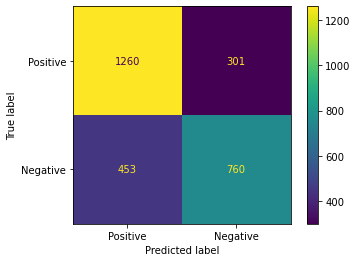

In [120]:
# calculate the matrix for the K-Nearest Neighbours Classifier
cm_KNN = confusion_matrix(target_test, KNN_predicted, labels=target_categories)
# display it graphically
cmd_KNN = ConfusionMatrixDisplay(cm_KNN, display_labels=target_categories)
cmd_KNN.plot();

The confusion Matrix shows that <b>301</b> Positive Reviews were predicted to be Negative, and <b>453</b> Negative Reviews were predicted to be Positive using the K-Nearest Neighbours Classifier model.

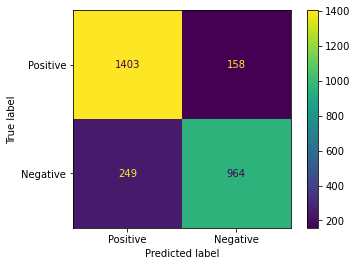

In [121]:
# calculate the matrix for the  Logistic Regression Classifier
cm_Loigic_Regr_ = confusion_matrix(target_test, Loigic_Regr_predicted, labels=target_categories)
# display it graphically
cmd_Loigic_Regr_ = ConfusionMatrixDisplay(cm_Loigic_Regr_, display_labels=target_categories)
cmd_Loigic_Regr_.plot();

The confusion Matrix shows that <b>158</b> Positive Reviews were predicted to be Negative, and <b>249</b> Negative Reviews were predicted to be Positive using the Logistic Regression Classifier model.

Using both models, it is observed that more negative reviews were predicted to be postive than the other way around.This could be as because of the stop words used, some of the words could have caused a wrong prediction.It could aslo be because, some negative reviews are filled with use of sacarsms to express disatisfactions.Ths could have also caused wrong predictions.

We can look at <b>precision</b>, <b>recall</b>  and <b>F1 measure</b> scores for both classes using using scikit-learn's <i>classification_report</i> function.

In [122]:
#Summary of statistics of K-Nearest Neighbour model
print("Classification summary for K-Nearest Neighbour model")
print(classification_report(target_test, KNN_predicted, target_names=target_categories))

Classification summary for K-Nearest Neighbour model
              precision    recall  f1-score   support

    Positive       0.72      0.63      0.67      1213
    Negative       0.74      0.81      0.77      1561

    accuracy                           0.73      2774
   macro avg       0.73      0.72      0.72      2774
weighted avg       0.73      0.73      0.73      2774



From the above summary, the K-Nearest Neighbour model shows that precision is higher when predicting positive reviews compared to negative reviews.Recall is higher for negative reviews i.e there is higher proportion of relevant results that are retrieved for negative reviews.The F1 score is Higher for negative reviews.

In [123]:
#Summary of statistics of Logistic Regression model
print("Classification summary for Logistic Regression model")
print(classification_report(target_test, Loigic_Regr_predicted, target_names=target_categories))

Classification summary for Logistic Regression model
              precision    recall  f1-score   support

    Positive       0.86      0.79      0.83      1213
    Negative       0.85      0.90      0.87      1561

    accuracy                           0.85      2774
   macro avg       0.85      0.85      0.85      2774
weighted avg       0.85      0.85      0.85      2774



 Logistic Regression model also has higher positive review precision and higher negative review recall.Hence, F1 is Higher for Negative reviews.

In both classifier models, of all Positive and Negative predictions, there is a higher portion of reviews that are actually Postive than Negative-Precision.Also, of all real Positive and Negative reviews, there are more predicted Negative reviews than Positive reviews.

Dislaimer:The Results above are subject to change every time the cell is run.This is because the splitting of data and target to training and testing is random, so the proportion wll change every time.Nevertheless, the general results of more right and more wrong predictions are the same.

Finally, We look at evaluates the Classifiers with <b>Cross Validation</b>

This will be done using a 10-fold cross validation 

In [124]:
# apply 10-fold cross-validation to  K-Nearest Neighbour pipeline model, measuring accuracy each time.
acc_scores_KNN =  cross_val_score(pipeline_KNN, documents, target, cv=10, scoring="accuracy")
print(acc_scores_KNN)

[0.7427027  0.74054054 0.75351351 0.75567568 0.74025974 0.73160173
 0.73701299 0.7478355  0.73809524 0.75541126]


Calculate the average accuracy across all folds:

In [125]:
s_acc_KNN = pd.Series(acc_scores_KNN)
print("Mean accuracy of K-Nearest Neighbour model: %.4f" % s_acc_KNN.mean())

Mean accuracy of K-Nearest Neighbour model: 0.7443


In [126]:
# apply 10-fold cross-validation to Logistic Regression pipeline model, measuring accuracy each time.
acc_scores_logic_regr =  cross_val_score(pipeline_logic_regr, documents, target, cv=10, scoring="accuracy")
print(acc_scores_logic_regr)

[0.86594595 0.85945946 0.85513514 0.87675676 0.85497835 0.86471861
 0.86471861 0.86147186 0.8495671  0.86471861]


Calculate the average accuracy across all folds:

In [127]:
s_acc_logic_regr = pd.Series(acc_scores_logic_regr)
print("Mean accuracy of Logistic Regression model: %.4f" % s_acc_logic_regr.mean())

Mean accuracy of Logistic Regression model: 0.8617


Concluding with the cross validation evaluation, the Logistic Regression classifier model is more accurate than the K-Nearest Neighbour classfier model at predicating what revies are Positive reviews, and Negative reviews.

# Task 3-Review Helpfulness Classification

Our documents here are given by the Title-Review Column.Our target variable is given by a new Helpfulness Class Label column, where 'Helpful' indicates a helpful review and 'Unhelpful' indicates an unhelpful review.

In [128]:
documents=df_reviews["Title-Review"]
target_categories=["Helpful", "Unhelpful"]
# Class labels for all documents
target=df_reviews['Helpfulness']

Firstly, Split the data, so that we have 70% in the training set and 30% in the test set

In [133]:
data_train, data_test, target_train, target_test = train_test_split(documents, target, test_size=0.3)

## Classification  - Logistic Regression

We use Logistic Regression from scikit-learn as a Classfier.Pipleine from Sckitlearn will be used for the preprocessing techniques which are <i>case conversion, lemmanisation, stop-word filtering,low frequency term filtering = 3</i> and classification.

In [134]:
pipeline_logic_regr2 = Pipeline([
    ('vec', CountVectorizer(min_df = 3, stop_words=stopword,tokenizer=lemma_tokenizer,lowercase=True)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=0))
])

Now we can train the model using the pipeline:

In [135]:
pipeline_logic_regr2.fit(data_train, target_train)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=3,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
                      

Use pipeline to test the model on the set of test documents

In [136]:
Loigic_Regr_predicted2 = pipeline_logic_regr2.predict(data_test)

## Classification  -  linear Support Vector Machine (SVM)

We use  linear Support Vector Machine (SVM) from scikit-learn as a Classfier.Pipleine from Sckitlearn will be used for the preprocessing techniques which are <i>case conversion, lemmanisation, stop-word filtering,low frequency term filtering = 3</i> and classification.

In [137]:
pipeline_SVM = Pipeline([
    ('vec', CountVectorizer(min_df = 3, stop_words=stopword,tokenizer=lemma_tokenizer,lowercase=True)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

Now we can train the model using the pipeline:

In [138]:
pipeline_SVM.fit(data_train, target_train)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=3,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
                      

Use pipeline to test the model on the set of test documents

In [139]:
SVM_predicted = pipeline_SVM.predict(data_test)

## Evaluation of Classifiers

Now we will evaluate the performance of the classifiers. 

Firstly, we can just look at the <b>overall accuracy</b>

In [140]:
print("Classification accuracy of  Logistic Regression = %.4f" % accuracy_score(target_test, Loigic_Regr_predicted2))
print("Classification accuracy of Support Vector Machine= %.4f" % accuracy_score(target_test, SVM_predicted))

Classification accuracy of  Logistic Regression = 0.8295
Classification accuracy of Support Vector Machine= 0.8493


The results of the overall accuracy shows that the Support Vector Machine classifier model is more accurate than Logistic Regression Classifier Model in predicting the helpfulness of the reviews.There are more correct predictions with the SVM model than the logistice regression model.

Next, we will look at the <b>confusion matrix</b> to see where the errors lie:

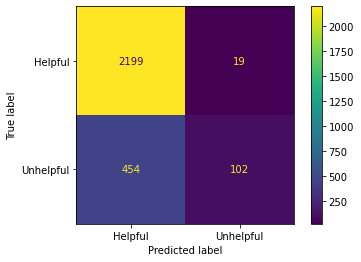

In [141]:
# calculate the matrix for the Logistic Regression Classifier
cm__Loigic_Regr_2 = confusion_matrix(target_test, Loigic_Regr_predicted2, labels=target_categories)
# display it graphically
cm__Loigic_Regr_2 = ConfusionMatrixDisplay(cm__Loigic_Regr_2, display_labels=target_categories)
cm__Loigic_Regr_2.plot();

The confusion Matrix shows that only <b>19</b> Helpful Reviews were predicted to be Unhelpful, and <b>454</b> Unhelpful Reviews were predicted to be Helpful using the Logistic Regression Classifier model.This model performed poorly in predicting the Unhelpfulness of reviews as there were more wrong predictions than right ones.

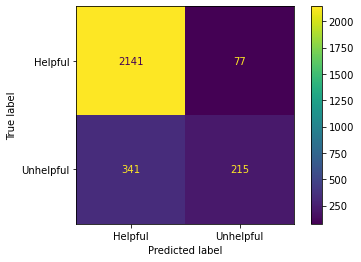

In [142]:
# calculate the matrix for the Support Vector Machine Classifier
cm_SVM = confusion_matrix(target_test, SVM_predicted, labels=target_categories)
# display it graphically
cm_SVM = ConfusionMatrixDisplay(cm_SVM, display_labels=target_categories)
cm_SVM.plot();

The confusion Matrix shows that only <b>77</b> Helpful Reviews were predicted to be Unhelpful, and <b>341</b> Unhelpful Reviews were predicted to be Helpful using the Support Vector Machine model.This model performed poorly in predicting the Unhelpfulness of reviews as there were more wrong predictions than right ones.

Results from the confusion matrix of both models shows that in predicting the helpfulness of the reviews, more helpful reviews are predicted correctly, while more unhelpful reviews are predicted wrongly in both models.It is an understandable results because sometimes, the content of reviews do not determine whether a user finds it useful or not.It all depends on if the user chooses to relate with the review or not.In some cases, if the product being reviewed are the same as the users product of interest, ths could also influence the usefulness of the review to the user.

We can look at <b>precision</b>, <b>recall</b>  and <b>F1 measure</b> scores for both classes using using scikit-learn's <i>classification_report</i> function.

In [146]:
#Summary of statistics of Logistic Regression model
print("Classification summary for Logistic Regression model")
print(classification_report(target_test, Loigic_Regr_predicted2, target_names=target_categories))

Classification summary for Logistic Regression model
              precision    recall  f1-score   support

     Helpful       0.83      0.99      0.90      2218
   Unhelpful       0.84      0.18      0.30       556

    accuracy                           0.83      2774
   macro avg       0.84      0.59      0.60      2774
weighted avg       0.83      0.83      0.78      2774



From the above summary, the Logistic Regression model shows that precision is higher when predicting unhelpful reviews compared to helpful reviews.Recall is a lot higher for helpful reviews i.e there is higher proportion of relevant results that are retrieved for helpful reviews.The F1 score is Higher for helpful reviews.

In [147]:
#Summary of statistics of Support Vector Machine model
print("Classification summary for Support Vector Machine model")
print(classification_report(target_test, SVM_predicted, target_names=target_categories))

Classification summary for Support Vector Machine model
              precision    recall  f1-score   support

     Helpful       0.86      0.97      0.91      2218
   Unhelpful       0.74      0.39      0.51       556

    accuracy                           0.85      2774
   macro avg       0.80      0.68      0.71      2774
weighted avg       0.84      0.85      0.83      2774



In the case of the Support Vector Machine model, both precision and recall are higher for helpful reviews.The F1 measures for helpful review is a lot higher for helpful reviews also.

The Logistic regression model shows that there were a slightly larger portion of actual unhelpful reviews that were predicted correctly.There was also a larger portion for the case of actual helpful reviews.Also, More portions of the predicted helpful reviews were actually correct, compared to the unhelpful reviews predictions.

The Support Vector Machine model showed slightly different results.It showed that More portion of the predicted helful reviews were actually correst and more portions of the actual helpful reviews were predicted correctly compared to the actual unhelpful predictions.

Dislaimer:The Results above are subject to change every time the cell is run.This is because the splitting of data and target to training and testing is random, so the proportion wll change every time.Nevertheless, the general results of more right and more wrong predictions are the same.

Finally, We look at evaluates the Classifiers with <b>Cross Validation</b>

This will be done using a 10-fold cross validation 

In [149]:
# apply 10-fold cross-validation to  Logistic regression model, measuring accuracy each time.
acc_scores_logic_regr_2 =  cross_val_score(pipeline_logic_regr2, documents, target, cv=10, scoring="accuracy")
print(acc_scores_logic_regr_2)

[0.84324324 0.85405405 0.84432432 0.84756757 0.83549784 0.83441558
 0.83766234 0.84415584 0.8452381  0.83874459]


Calculate the average accuracy across all folds:

In [150]:
s_acc_scores_logic_regr_2 = pd.Series(acc_scores_logic_regr_2)
print("Mean accuracy of Logistic regression model: %.4f" % s_acc_scores_logic_regr_2.mean())

Mean accuracy of Logistic regression model: 0.8425


In [151]:
# apply 10-fold cross-validation to Support Vector Machine model, measuring accuracy each time.
acc_SVM =  cross_val_score(pipeline_SVM , documents, target, cv=10, scoring="accuracy")
print(acc_SVM)

[0.85837838 0.86702703 0.8572973  0.86486486 0.8538961  0.85064935
 0.84415584 0.85497835 0.87012987 0.8517316 ]


Calculate the average accuracy across all folds:

In [152]:
s_acc_SVM = pd.Series(acc_SVM)
print("Mean accuracy of Support Vector Machine model: %.4f" % s_acc_SVM.mean())

Mean accuracy of Support Vector Machine model: 0.8573


The mean accuracy of the Support Vector Machine model is considerably higher than the Logistic Regression Model when predicting the helpfullness of reviews.

# Comparing the classifications for Task 2 and 3

In Task 2, the review class label was either positive or negative reviews.The most accurate classifier model was the Logistic Regression Model.Had higher overall accuracy and also higher cross-validation mean ccuracy than the K-Nearest Neighbour Model.The K-Nearest Neighbour model is known to be a simple or 'lazy' model so the results only validated that. Also,results in the confusion matrix showed more actual negative reviews were predicted to be positive reviews in both models.As stated before this could be as a results of the use of some not so appropriate stop words, or cause some negative reviews are sacarstic and could seem positive to the models.

In Task 3, the class label was either helpful or unhelpful reviews.Because of the success of the Logistic Regression classifier, it was used to as a model in this task.The Support Vector Machine classifier was also used to model a predictor.The results showed that the SVM classifier was more accurate overall than the Logistic Regression classifier. More helful review were predicted corretly in both models.Also there were a lot of unhelpful review predicted wrongly than right.This was the case for both models also.

# Conclusion

In conclusion, in order of the most accurate classifier, its the Support Vector Machine, Logistic Regression classifier and then the K-Nearest Neighbour Model.
For future analysis, it will be important to see if increasing the number of k, will improve the accuracy of the K-Nearest Neighbour Model.Also using other classifiers such as Decision Tree Classifiers/Random Forests, Naive Bayes and Linear Discriminant Analysis to perfom Task 2 and Task 3 will be considered.It will be important to get the most accurate classifier for machine learning and predicting.Analysis that would involve predicting multiple classses will also be considered.